# Global imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Customized score functions
from qksvm.scores import get_scores, print_scores, print_cv_scores

# Custom visualization tools
from qksvm.visualization_tools import plot_dataset, plot_predictions, plot_decisions

seed = 12345

# Dataset: 4 folded diffused circles

In [2]:
from sklearn.datasets import make_circles
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
np.random.seed(seed=7)

n_samples = 100
radii = [2.0, 5.0]
factors = [0.5, 0.7]

X = []
y = []

for i, d in enumerate(radii):
    _X, _y = make_circles(n_samples=int(n_samples*d), noise=0.1, random_state=81, factor=factors[i])
    for i, _ in enumerate(_y):
        X.append(_X[i,:]*d)
        y.append(_y[i])
    
X = np.array(X)
y = np.array(y)
y = 2*y-1 # rescale to [-1,1]

# plt.figure(figsize=(5,5))
# plt.scatter(X[:, 0], X[:, 1], s=50, c=y, marker='o', cmap=plt.cm.Paired)
# plt.show()

xmin = -1; xmax = 1
X = MinMaxScaler(feature_range=(xmin, xmax), copy=False).fit_transform(X)
# X = MaxAbsScaler().fit_transform(X)

# shuffle dataset elements
def unison_shuffled(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, y = unison_shuffled(X, y)
print(X.shape)

(700, 2)


Training target statistics: Counter({1: 25, -1: 25})
Testing target statistics: Counter({-1: 25, 1: 25})


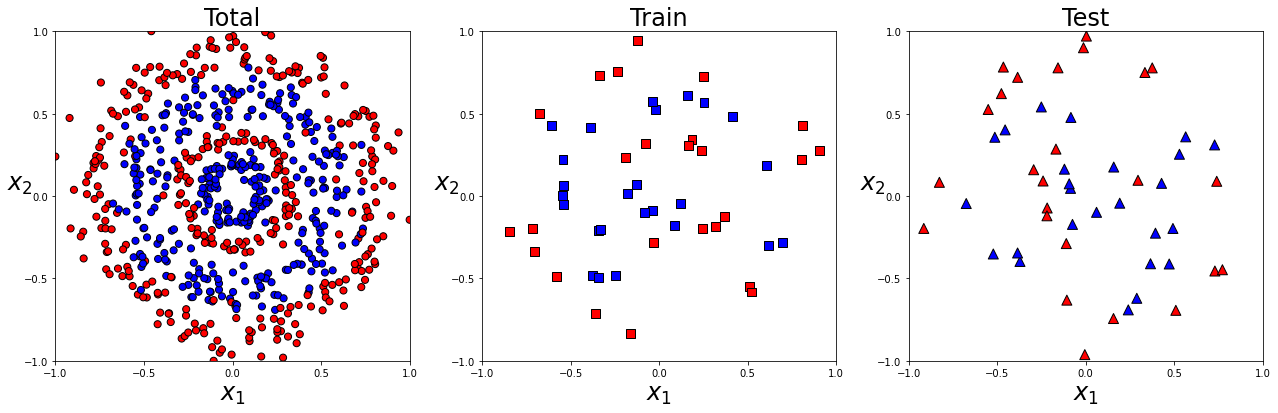

In [3]:
from sklearn.model_selection import train_test_split

train_size = 50
test_size = 50
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size,
    stratify=y, random_state=42,
)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

# Visualize the dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=24)
plot_dataset(X, y, ax1, axes)

ax2.set_title("Train", fontsize=24)
plot_dataset(X_train, y_train, ax2, axes, marker='s', size=80)

ax3.set_title("Test", fontsize=24)
plot_dataset(X_test, y_test, ax3, axes, marker='^', size=100)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

# RBF SVM

## Training

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

param_grid = {
    "gamma": [0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10.0],
    "C": [1, 2, 4, 6, 8, 10, 100, 1000],
}

clf = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=seed),
)
clf.fit(X_train, y_train)

print('Best grid search parameters:', clf.best_params_)
print('Best training score:', clf.best_score_)

Best grid search parameters: {'C': 2, 'gamma': 10.0}
Best training score: 0.6778846153846154


## Predictions/Decision boundaries plot

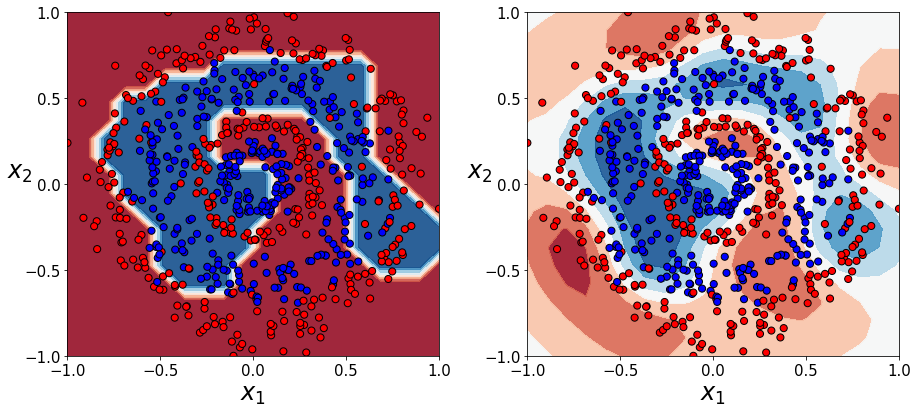

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(clf.best_estimator_, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(clf.best_estimator_, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()

## Model cross-validation

In [6]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

# train_size = 50
# test_size = 50

param_grid = {
    "gamma": [0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10.0],
    "C": [1, 2, 4, 6, 8, 10, 100, 1000],
}

n_splits = 5
# cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)
cv = StratifiedShuffleSplit(
    n_splits=n_splits, 
    train_size=train_size, test_size=test_size, 
    random_state=seed
)

i = 0
for train, test in cv.split(X, y):
    i += 1
    print(f"Train/Test CV Subset {i}")

    clf = GridSearchCV(
        estimator=SVC(kernel='rbf'),
        param_grid=param_grid,
        scoring='balanced_accuracy',
        n_jobs=1,
        refit=True,
        cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=seed),
    )
    
    clf.fit(X[train,:], y[train])
   
    train_scores = get_scores(clf.best_estimator_, X[train,:], y[train])
    test_scores = get_scores(clf.best_estimator_, X[test,:], y[test])
    scores_tr.append(train_scores)
    scores_tt.append(test_scores)
    if test_scores[scoring] > best_score:
        best_score = test_scores[scoring]
        best_clf = clf.best_estimator_

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')

Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5

==== Cross-Validation Scores ====

Best train score:  0.74

Train set:
   Balanced accuracy:  0.80 +- 0.09
                  F1:  0.80 +- 0.09
             ROC_AUC:  0.80 +- 0.09
                 MCC:  0.62 +- 0.19

Test set:
   Balanced accuracy:  0.64 +- 0.12
                  F1:  0.64 +- 0.12
             ROC_AUC:  0.64 +- 0.12
                 MCC:  0.30 +- 0.24


In [7]:
scores_ = get_scores(best_clf, X, y)
print_scores(scores_, title='Entire set:')


Entire set:
   Balanced accuracy:  0.66
                  F1:  0.66
             ROC_AUC:  0.66
                 MCC:  0.31


## Best CV Predictions/Decision boundaries plot

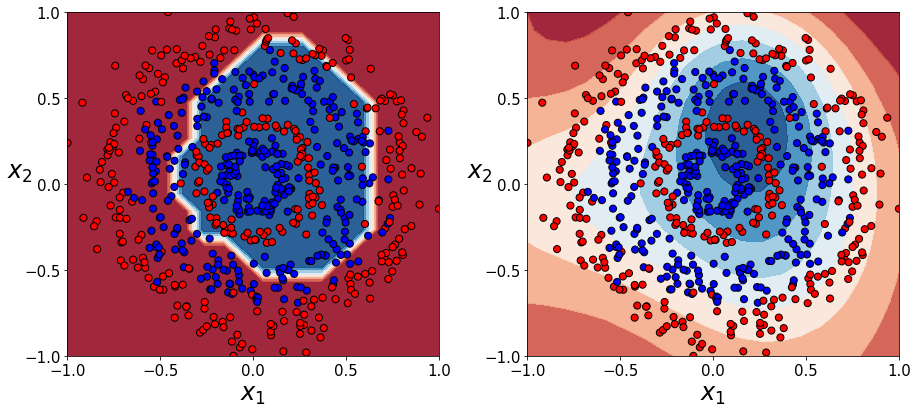

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(best_clf, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(best_clf, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()

# QKT SVM

## Setting up the quantum feature map 

In [9]:
from qksvm.QuantumFeatureMap import QuantumFeatureMap

fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=2,
    num_layers=4,
    gates=['RX', 'cz'], entanglement='linear',
    repeat=True,
    scale=True,
)
print(fm.draw(plot_barriers=False, fold=120))

     ┌───────────────┐     ┌───────────────┐     ┌───────────────┐     ┌───────────────┐     
q_0: ┤ Rx(x[0]*θ[0]) ├──■──┤ Rx(x[0]*θ[0]) ├──■──┤ Rx(x[0]*θ[0]) ├──■──┤ Rx(x[0]*θ[0]) ├──■──
     ├───────────────┤  │  ├───────────────┤  │  ├───────────────┤  │  ├───────────────┤  │  
q_1: ┤ Rx(x[1]*θ[0]) ├──■──┤ Rx(x[1]*θ[0]) ├──■──┤ Rx(x[1]*θ[0]) ├──■──┤ Rx(x[1]*θ[0]) ├──■──
     └───────────────┘     └───────────────┘     └───────────────┘     └───────────────┘     


## Examine dependence of the kernel loss function on the data scaling prefactor

In [10]:
#------------------------
# Choose quantum backend
#------------------------
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = seed
backend = QuantumInstance(
    AerSimulator(
        method='statevector',
        max_parallel_threads=8,
    ),
    seed_simulator=seed, seed_transpiler=seed,
)

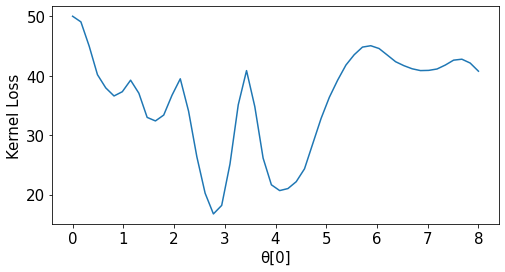

In [11]:
from qksvm.LossFunctions import SVCLoss
from qiskit_machine_learning.kernels import QuantumKernel

loss = SVCLoss(C=1)

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

kernel = QuantumKernel(fm, user_parameters=fm.train_params, quantum_instance=backend)
loss.plot(kernel, X_train, y_train, init_params, grid=[0, 8, 50], show=True)

## Quantum Kernel Training

SVCLoss optimal value:  16.65769820930539
Optimal parameters: [2.81011679]


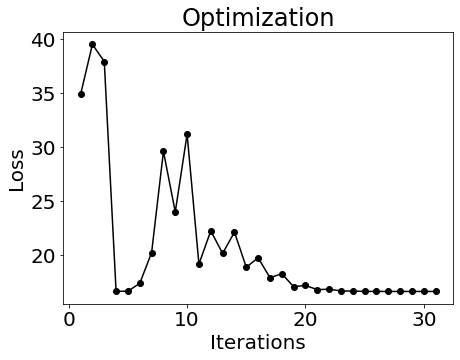


Train scores:
   Balanced accuracy:  0.88
                  F1:  0.88
             ROC_AUC:  0.88
                 MCC:  0.77

Test scores:
   Balanced accuracy:  0.76
                  F1:  0.76
             ROC_AUC:  0.76
                 MCC:  0.54


In [12]:
from qksvm.QuantumKernelTraining import QuantumKernelTraining
from sklearn.svm import SVC

C = 1.0
class_weight = None

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 2.0

qkt = QuantumKernelTraining(
    fm,
    X_train, y_train,
    init_params,
    seed=seed, plot=True,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

In [13]:
scores_ = get_scores(qsvc, X, y)
print_scores(scores_, title='Entire set:')


Entire set:
   Balanced accuracy:  0.82
                  F1:  0.82
             ROC_AUC:  0.82
                 MCC:  0.65


## Predictions/Decision boundaries plot

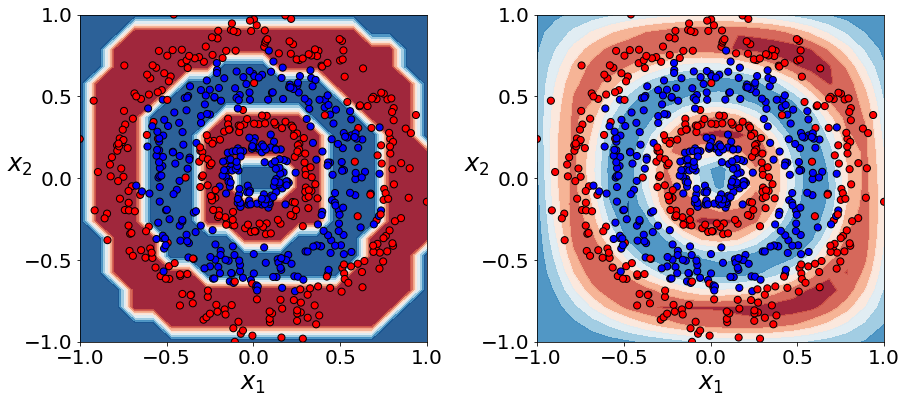

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()

## Model cross-validation

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

# train_size = 50
# test_size = 50

n_splits = 5
# cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)
cv = StratifiedShuffleSplit(
    n_splits=n_splits, 
    train_size=train_size, test_size=test_size, 
    random_state=seed
)

i = 0
for train, test in cv.split(X, y):
    i += 1
    print(f"Train/Test CV Subset {i}/{n_splits}", end='\r')
    
    # Model training
    qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
    qsvc.fit(X[train], y[train])
    
    scores_tr.append(get_scores(qsvc, X[train], y[train]))
    scores_tt.append(get_scores(qsvc, X[test], y[test]))
    if scores_tt[-1][scoring] > best_score:
        best_score = scores_tt[-1][scoring]
        best_qsvc = qsvc

print('\n\n==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')

Train/Test CV Subset 5/5

==== Cross-Validation Scores ====

Best train score:  0.86

Train set:
   Balanced accuracy:  0.82 +- 0.03
                  F1:  0.82 +- 0.03
             ROC_AUC:  0.82 +- 0.03
                 MCC:  0.65 +- 0.07

Test set:
   Balanced accuracy:  0.78 +- 0.05
                  F1:  0.78 +- 0.05
             ROC_AUC:  0.78 +- 0.05
                 MCC:  0.57 +- 0.10


In [16]:
scores_ = get_scores(best_qsvc, X, y)
print_scores(scores_, title='Best model / Entire set:')


Best model / Entire set:
   Balanced accuracy:  0.83
                  F1:  0.83
             ROC_AUC:  0.83
                 MCC:  0.66


## Best CV Predictions/Decision boundaries plot

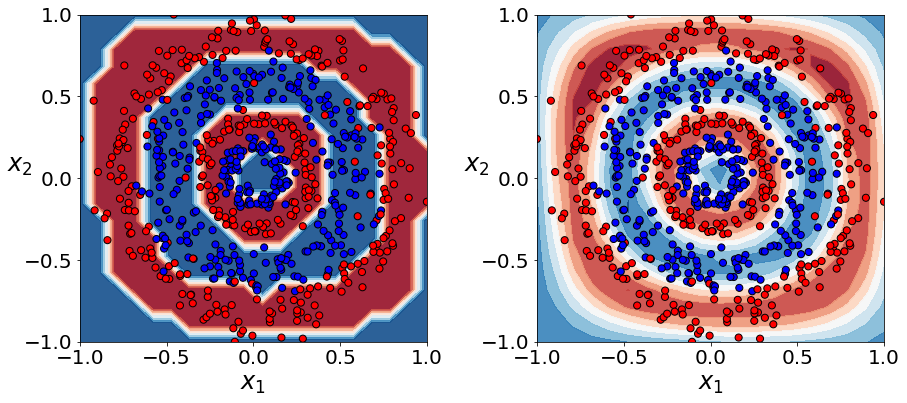

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(best_qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(best_qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()